In [53]:
using Base.Threads
println("Number of threads: ", nthreads())


# To set threads go to command prompt 
# see how many threads are available on the CPU with:
# wmic cpu get NumberOfLogicalProcessors
# Set the number of threads you want to use with:
# set JULIA_NUM_THREADS=6 (6 as an example)
# code .


Number of threads: 1


In [54]:
using Revise  # auto reload

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("MCMC.jl")
using .MCMC

includet("Particle.jl")
using .ParticleFilter




using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots
using StatsPlots
using CSV
using DataFrames

using MCMCChains  # For diagnostics
using ArviZ


## Model & Priors

In [55]:
# Parameters in θ
θ_elements = ["ρ", "λ_c", "σ²_ε, y", "σ²_ξ, y", "σ²_κ, y"]
n_params = length(θ_elements)
# cycle_order
cycle_order = 2

# Create the support matrix
support = [
    0.0 0.97  # ρ
    0.0 π;  # λ_c
    0.0 Inf;  # σ²_ε, y
    0.0 Inf;  # σ²_ξ, y
    0.0 Inf  # σ²_κ, y 
]

# Create the prior distributions 
prior_distributions = (
    "uniform",  # ρ
    "uniform",  # λ_c
    "inverse_gamma",  # σ²_ε, y
    "inverse_gamma",  # σ²_ξ, y 
    "inverse_gamma",  # σ²_κ, y
)

# Create the prior hyperparameters matrix
prior_hyperparameters = [
    0.0 0.96;  # ρ
    0.0 3.0;  # λ_c
    1e-6 1e-6;  # σ²_ε, y
    1e-6 1e-6;  # σ²_ξ, y
    1e-6 1e-6  # σ²_κ, y
]

# Combine into a named tuple
prior_info = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters,
)


#States in α
α_elements = [
    "u_t^y", 
    "β_t^y", 
    "ψ_{2,t}^y", 
    "ψ_{2,t}^{y*}", 
    "ψ_{1,t}^y", 
    "ψ_{1,t}^{y*}", 
]



6-element Vector{String}:
 "u_t^y"
 "β_t^y"
 "ψ_{2,t}^y"
 "ψ_{2,t}^{y*}"
 "ψ_{1,t}^y"
 "ψ_{1,t}^{y*}"

## Data

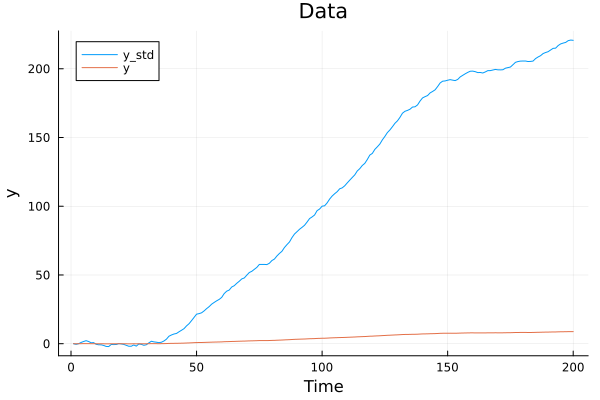

6×6 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

In [56]:
simulate = true


if simulate
    # True parameters
    ρ = 0.5
    λ_c = 0.1
    σ²_ε_y = 4*10e-5
    σ²_ξ_y = 4*10e-6
    σ²_κ_y = 6*10e-5
    # ρ = 0.6
    # λ_c = 0.1
    # σ²_ε_y = 7000
    # σ²_ξ_y = 100
    # σ²_κ_y = 8000
    # ρ = 0.5
    # λ_c = 0.1
    # σ²_ε_y = 0.5
    # σ²_ξ_y = 0.3
    # σ²_κ_y = 1.2

    θ_true = [ρ, λ_c, σ²_ε_y, σ²_ξ_y, σ²_κ_y]
    n_obs = 200
    y, α = simulate_data(θ_true, cycle_order, n_obs)
    y_std, σʸ = standardize_data(y)
    # y_std = y
    # σʸ = 1.0
    θ_true = [ρ, λ_c, σ²_ε_y, σ²_ξ_y, σ²_κ_y]


else
    # Load data 
    data = CSV.read("data.csv", DataFrame)
    # Extract y 
    y = data.y
    # make y a matrix
    y = Matrix(y')
    # log transform y
    # y = log.(y)
    println(size(y))
    y_std, σʸ = standardize_data(y)
    n_obs = length(y)
end


# plot data
plot(y_std[1,:], label="y_std", title="Standardized data", xlabel="Time", ylabel="y", legend=:topleft)
plot!(y[1,:], label="y", title="Data", xlabel="Time", ylabel="y", legend=:topleft)
display(plot!())

# Initial states
α0 = zeros(length(α_elements))
α0[1] = y[1]
P0 = 1*Matrix{Float64}(I, length(α_elements), length(α_elements))

In [57]:
log_L_particle, states_particle = particle_filter(y_std, θ_true, α0, P0, cycle_order, σʸ, N_particles = 5000)
Log_L_kalman, states_kalman, _ = diffuse_kalman_filter(y_std, θ_true, α0, P0, cycle_order, σʸ, true, false)

println("Log likelihood particle filter: ", log_L_particle)
println("Log likelihood kalman filter: ", Log_L_kalman)

println(size(states_particle))
println(size(states_kalman))	

# # plot states
# for i in 1:length(α_elements)
#     plot(states_particle[i,:], label="particle", title=α_elements[i], xlabel="Time", ylabel=α_elements[i], legend=:topleft)
#     plot!(states_kalman[i,:], label="kalman", title=α_elements[i], xlabel="Time", ylabel=α_elements[i], legend=:topleft)
#     display(plot!())
# end

Log likelihood particle filter: -226.97855651177534
Log likelihood kalman filter: -263.7968241524379
(6, 200)
(6, 200)


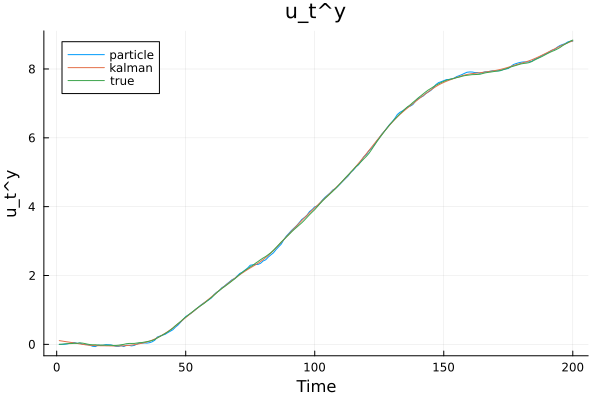

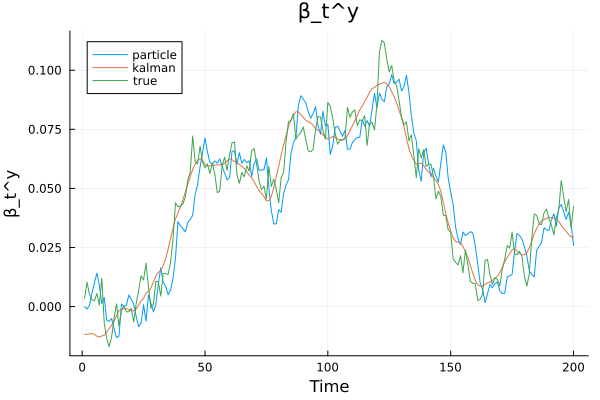

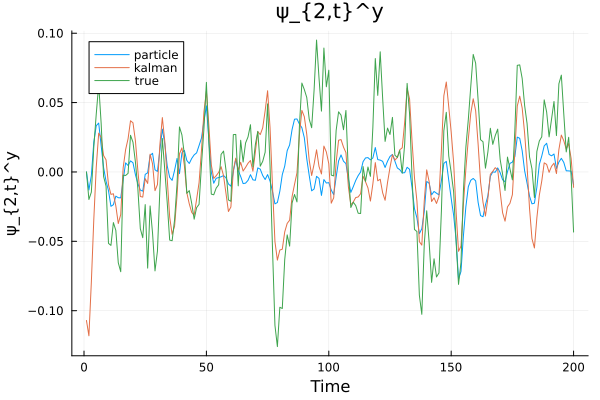

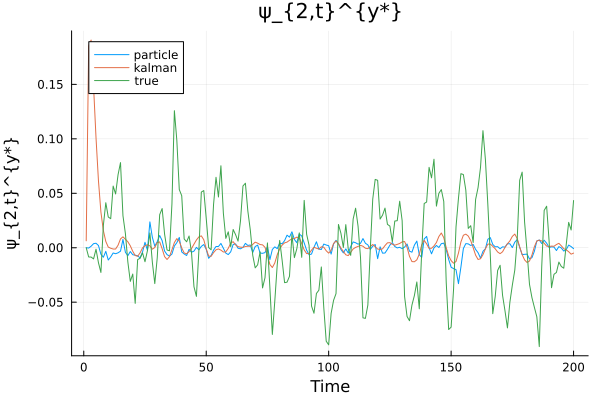

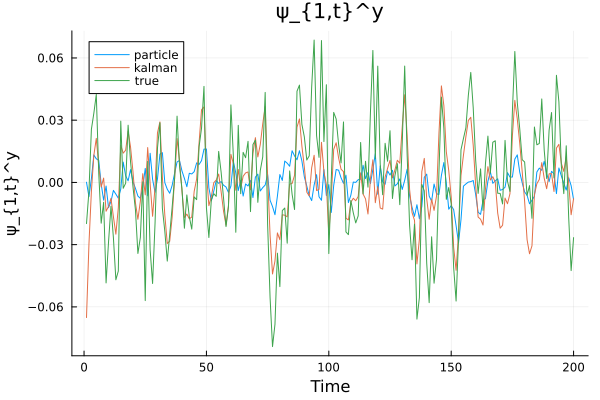

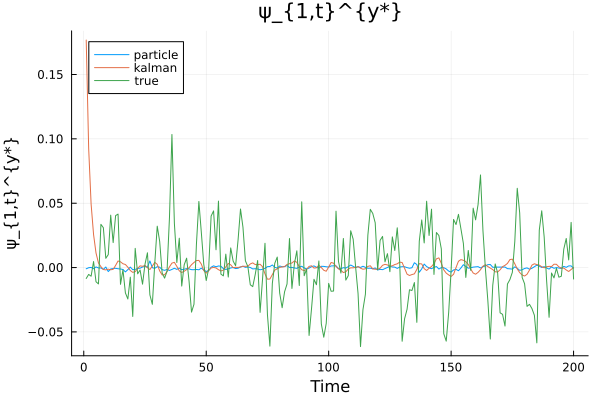

In [58]:
# plot states
for i in 1:length(α_elements)
    plot(states_particle[i,:], label="particle", title=α_elements[i], xlabel="Time", ylabel=α_elements[i], legend=:topleft)
    plot!(states_kalman[i,:], label="kalman", title=α_elements[i], xlabel="Time", ylabel=α_elements[i], legend=:topleft)
    #add true states
    plot!(α[i,:], label="true", title=α_elements[i], xlabel="Time", ylabel=α_elements[i], legend=:topleft)
    display(plot!())
end

## MCMC

In [59]:
# θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation_parallel(y_std, prior_info, α0, P0, cycle_order, σʸ;
#                                    filter_type="kalman",
#                                    iter_init=20000,
#                                    burn_init=10000,
#                                    iter_rec=20000,
#                                    burn_rec=10000,
#                                    ω=0.01,
#                                    target_low=0.25,
#                                    target_high=0.35,
#                                    n_chains=4)


In [60]:

θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation(y_std, prior_info, α0, P0, cycle_order, σʸ;
filter_type = "kalman",
iter_init = 10000, 
burn_init = 5000,
 iter_rec = 10000,
burn_rec = 5000,
ω = 1.0,
n_chains = 1)

println(size(θ_chain_all))
println(size(α_draws_all))



Starting chain 1 ...
Chain 1, Initial Parameters: [0.890660708307746, 0.44330132161133384, 8.84792132714181e9, 5.528395690013e8, 9.453239095782818e9]

Initialization Phase (chain 1)   1%|█                    |  ETA: 0:00:15

Initialization Phase (chain 1) 100%|█████████████████████| Time: 0:00:18


Chain 1, Initialization Acceptance Rate: 28.720000000000002%


Recursion Phase (chain 1) 100%|██████████████████████████| Time: 0:00:49


Chain 1, Recursion Acceptance Rate: 31.15%
Chain 1 completed in 68.36700010299683 seconds.
(5000, 5, 1)
(5000, 6, 200, 1)


Chains MCMC chain (10000×5×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
parameters        = ρ, λ_c, σ²_ε, y, σ²_ξ, y, σ²_κ, y

Summary Statistics
  parameters          mean             std          mcse   ess_bulk   ess_tail ⋯
      Symbol       Float64         Float64       Float64    Float64    Float64 ⋯

           ρ        0.5370          0.0848        0.0066   214.0241   191.9529 ⋯
         λ_c        0.1472          0.2330        0.0272    56.8078    59.2550 ⋯
     σ²_ε, y   663538.1190   25469079.3179   689768.6420    42.1058    43.7821 ⋯
     σ²_ξ, y    60883.3807    1954521.4361    63369.7292   235.0442    96.2729 ⋯
     σ²_κ, y   531761.7074   42188365.8557   540650.6055   164.8296   176.0169 ⋯
                                                               2 columns omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         

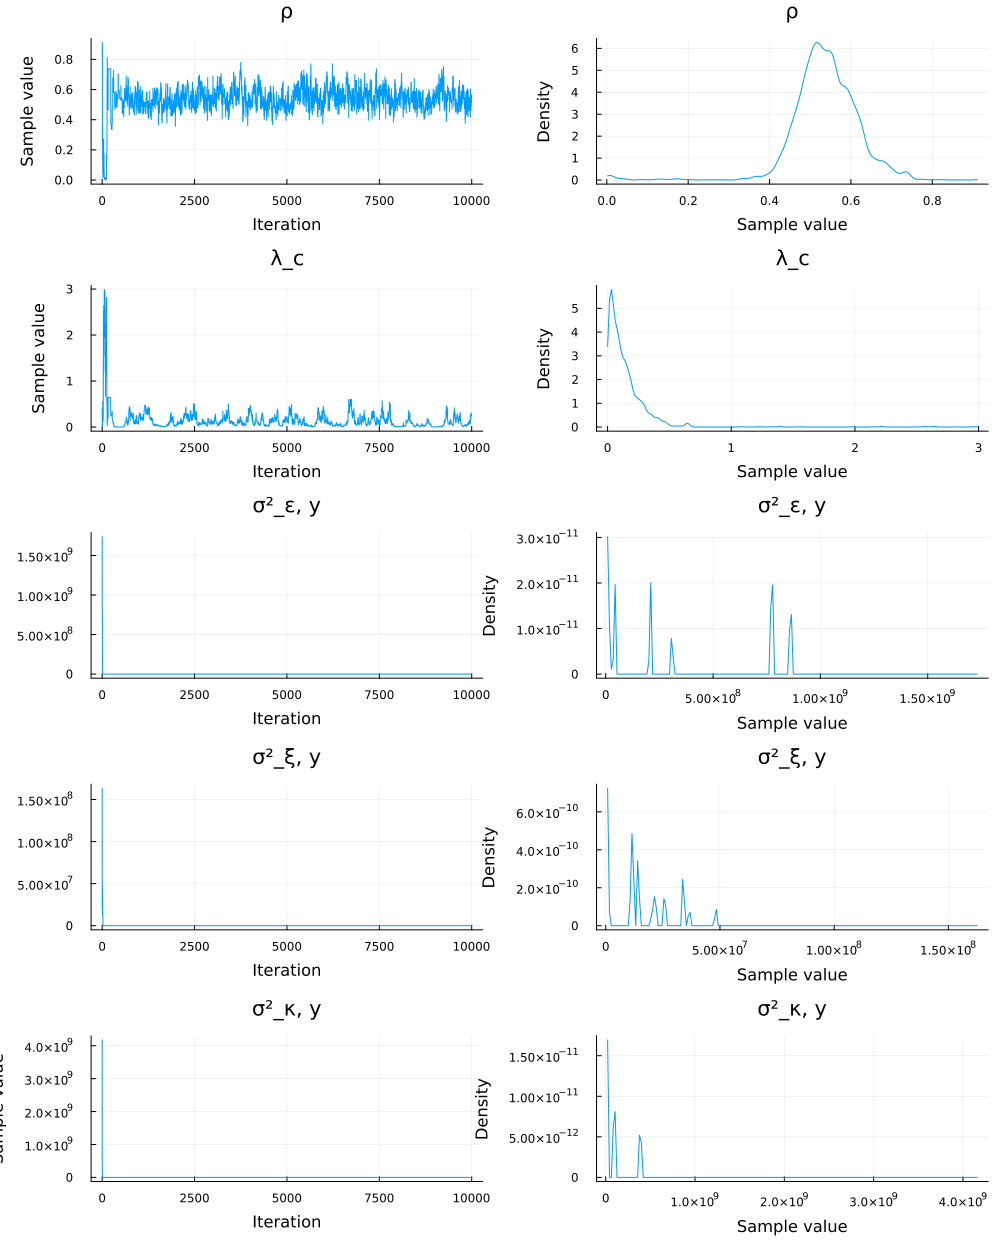

In [61]:
chain_init = Chains(θ_chain_init_all, θ_elements)
display(chain_init)
plot(chain_init)

Chains MCMC chain (5000×5×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = ρ, λ_c, σ²_ε, y, σ²_ξ, y, σ²_κ, y

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           ρ    0.5263    0.0660    0.0045   220.7690   359.6992    1.0006     ⋯
         λ_c    0.1117    0.1113    0.0077   152.0234   104.1148    1.0051     ⋯
     σ²_ε, y    0.0000    0.0000    0.0000   233.4305   345.2165    1.0083     ⋯
     σ²_ξ, y    0.0001    0.0000    0.0000   200.0051   275.5817    1.0033     ⋯
     σ²_κ, y    0.0005    0.0001    0.0000   207.4241   303.1351    1.0070     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           ρ

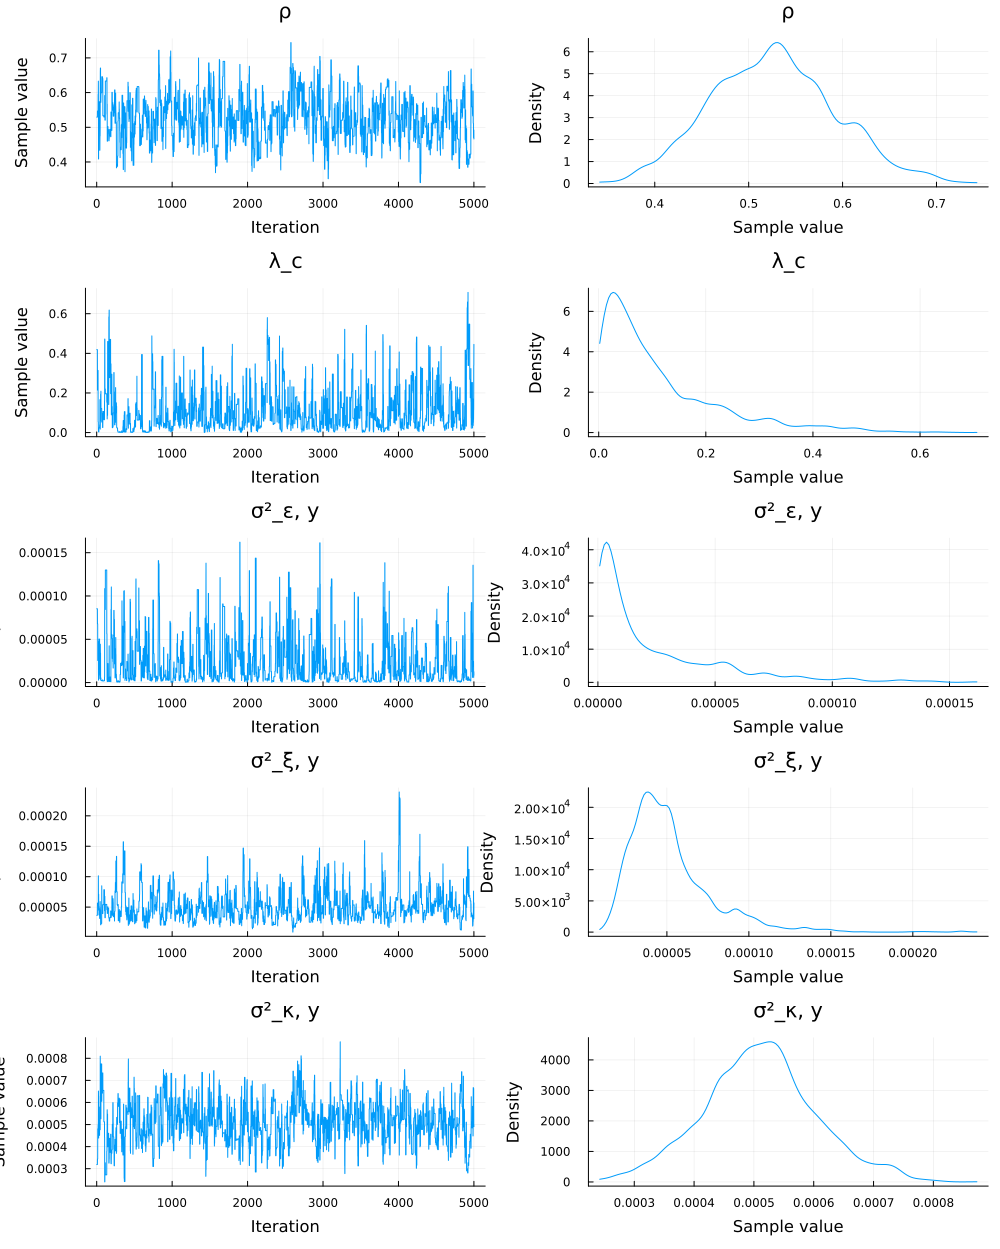

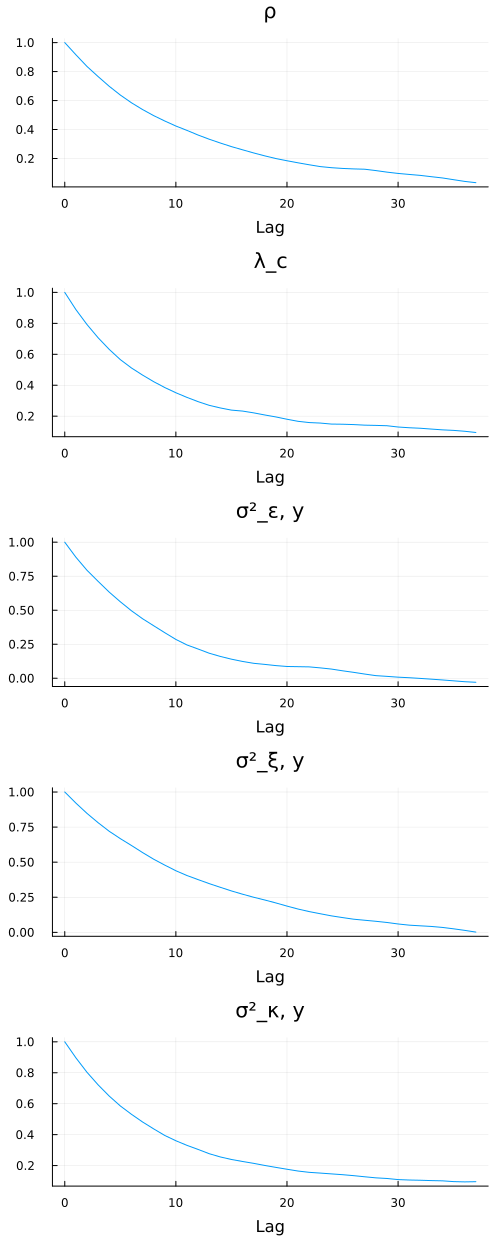

In [62]:

chain_rec = Chains(θ_chain_all, θ_elements)
display(chain_rec)

display(plot(chain_rec))
# display(corner(chain_rec))
display(autocorplot(chain_rec))

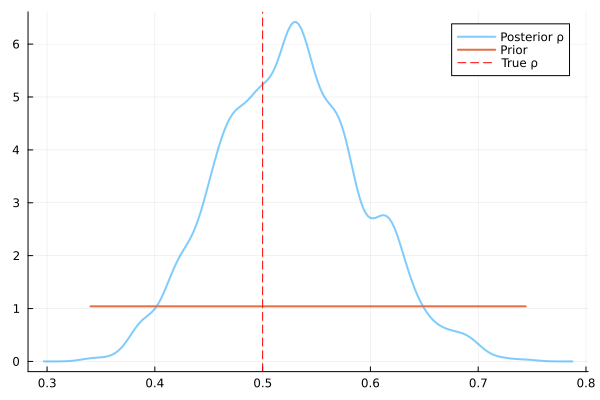

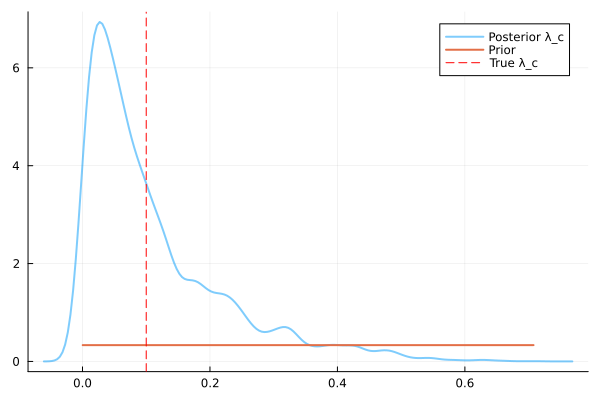

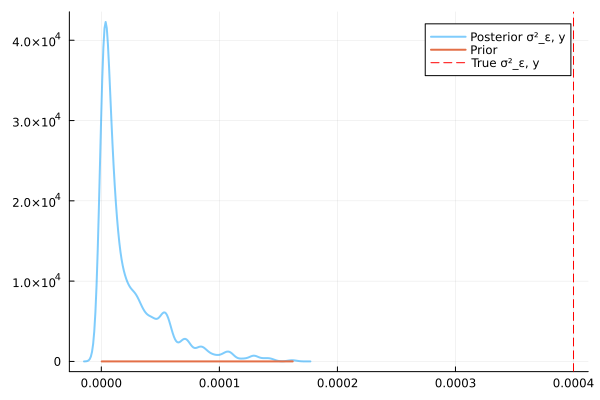

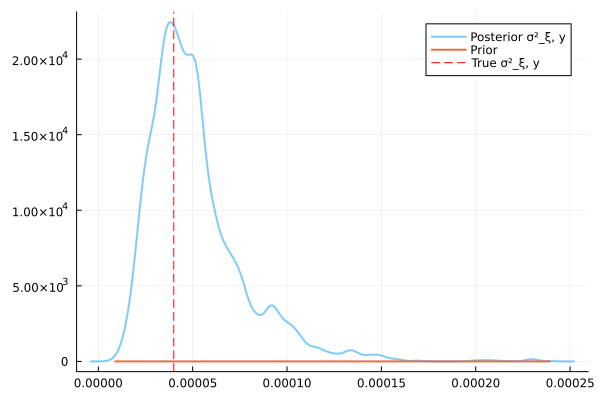

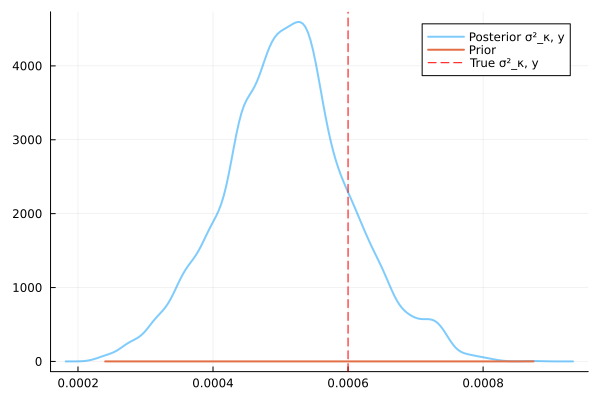

In [63]:
#analyze specific chain
chain = 1
θ_chain = θ_chain_all[:,:,:]

# Iterate through each parameter's chain
for i in 1:size(θ_chain, 2)
    # Plot kernel density estimate of the posterior
    density(θ_chain[:,i,:], label="Posterior $(θ_elements[i])", alpha=0.5, linewidth=2)

    # Prior distribution
    if prior_distributions[i] == "uniform"
        prior = Uniform(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "beta"
        prior = Beta(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "normal"
        prior = Normal(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "inverse_gamma"
        prior = InverseGamma(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    end
    x_vals = range(minimum(θ_chain[:,i,:]), maximum(θ_chain[:,i,:]), length=100)
    plot!(x_vals, pdf.(prior, x_vals), label="Prior", linewidth=2)

    # True value
    if simulate
        vline!([θ_true[i]], label="True $(θ_elements[i])", linestyle=:dash, color=:red)
    end

    # Display the plot
    display(plot!())
    
end



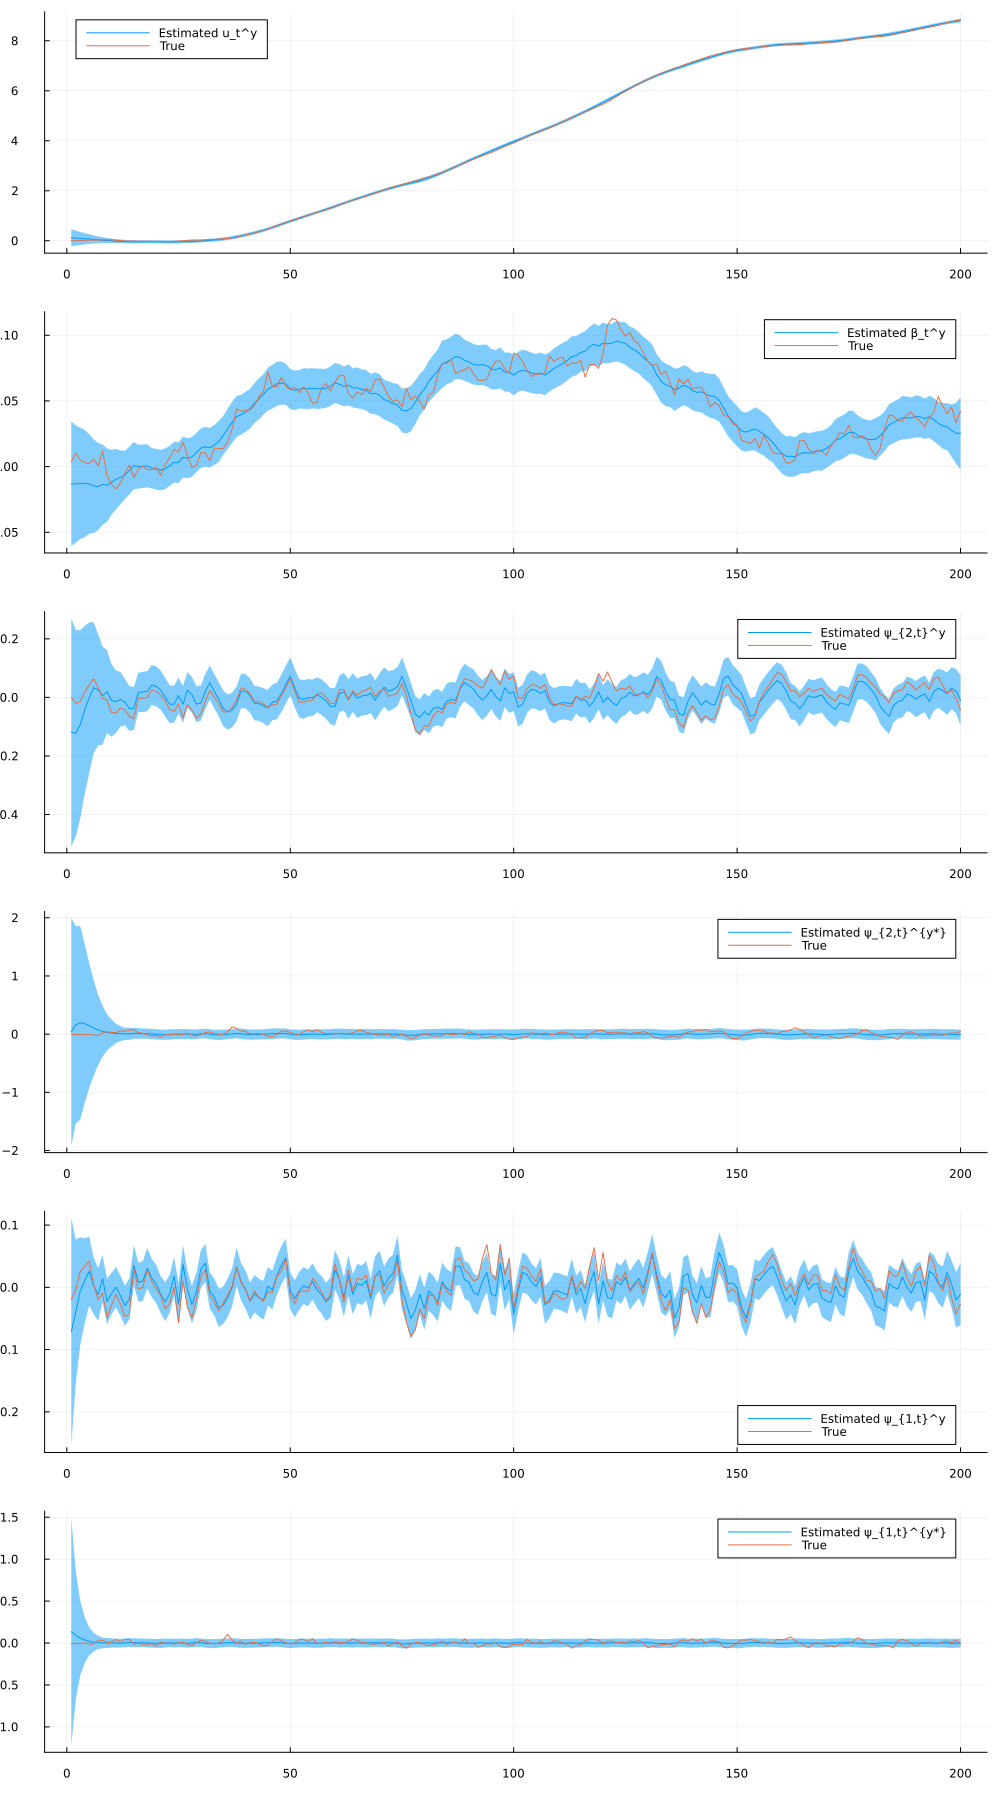

In [64]:
# α_draws_all has shape (iter_rec, state_dim, obs, n_chains)
n_chains = size(α_draws_all, 4)
n_states = size(α_draws_all, 2)


plots_vec = []
for i in 1:n_states
    for ch in 1:n_chains
        # Extract draws for the current chain 
        α_draws = α_draws_all[:,:,:,ch]
    
        # Compute the mean over iterations (dimension 1) 
        α_mean = dropdims(mean(α_draws, dims=1), dims=1)
    
        # Compute the 2.5% and 97.5% quantiles over iterations.
        α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)
    
        p = plot(α_mean[i, :],
                 ribbon = (α_ci[2, i, :] .- α_mean[i, :]),
                 label = "Estimated $(α_elements[i])")
        if simulate
            plot!(p, α[i, :], label = "True")
        end
        push!(plots_vec, p)
    end
end

combined_plot = plot(plots_vec..., layout = (n_states, n_chains), size=(1000, 300*n_states))
display(combined_plot)


## MLE

In [65]:
# using Optim


# lower_bounds = [0.0, 0.0, 1e-12, 1e-12, 1e-12]
# upper_bounds = [1.0, 3.0, 1e6, 1e6, 1e6]
# θ_init = [0.5, 1.5, 0.5, 0.5, 0.5]

# objective(θ) = neg_log_likelihood(θ, y, α0, P0, cycle_order, σʸ)
# res = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(BFGS()))
# θ_est = Optim.minimizer(res)

# # Print the results:
# println("MLE Results (with bounded optimization):")
# for (i, param_name) in enumerate(θ_elements)
#     println("Estimated $(param_name): $(θ_est[i])   (True value: $(θ_true[i]))")
# end
# println("Final negative log-likelihood: ", Optim.minimum(res))


In [66]:
# # estimate states
# LogL_diff, α_diff, P_diff = diffuse_kalman_filter(y, θ_est, α0, P0, cycle_order, σʸ,  true, false)

# #plot estimated states and true states
# for i in 1:size(α,2)
#     plot(α[:,i], label="true $(α_elements[i])")
#     plot!(α_diff[:,i], label="estimated $(α_elements[i])")
#     display(plot!())
# end

